## **Setup**

In [ ]:
!pip -q install torchmetrics decord fvcore pytorchvideo gdown ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.4 MB/s eta 0:00:00


In [ ]:
pip -q install --upgrade torch torchvision

In [ ]:
import json, random, csv, glob, os
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
from torchvision.transforms import v2
from decord import VideoReader, cpu
from PIL import Image
from dataclasses import dataclass
import torchvision
import numpy as np
from typing import Dict, Tuple, Optional, List
import pandas as pd
import math
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import random

def seed_all(seed=1023):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_all(2310)

## **1. CONFIGURATION**

In [ ]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

In [ ]:
class Config:
    def __init__(self):
        self.root_dir = "/content/drive/MyDrive/FIT3163,3164/SlowFast"
        self.clips_dir = os.path.join(self.root_dir, "05_clips/3in1")
        self.splits_dir = os.path.join(self.root_dir, "06_splits/3in1")
        self.models_dir = os.path.join(self.root_dir, "07_models/3in1_train5")
        self.best_model_path = os.path.join(self.models_dir, "best.pt")

        self.labels = [
            "smash", "jump_smash", "block",
            "drop", "clear", "lift", "drive",
            "straight_net", "cross_net", "serve",
            "push", "tap"
        ]

        self.batch_size = 8

        self.side: int = 256           # input size (square), original=224
        self.num_frames: int = 8       # frames per clip, original=8
        self.sample: str = "uniform"   # "uniform" or "rand"
        self.train_scale: Tuple[float,float] = (0.7, 1.0)
        self.train_ratio: Tuple[float,float] = (0.75, 1.333)

# Create a configuration object
cfg = Config()

In [ ]:
@dataclass
class VideoCfg:
    clips_dir: str
    splits_dir: str
    labels: List[str]
    side: int = 256           # input size (square), original=224
    num_frames: int = 12       # frames per clip, original=8
    sample: str = "uniform"   # "uniform" or "rand"
    train_scale: Tuple[float,float] = (0.7, 1.0)
    train_ratio: Tuple[float,float] = (0.75, 1.333)

## **2. DATA PREPARATION**
### This function handles all logic for splitting and saving the dataset.

In [ ]:
# Download dataset file
# !gdown --fuzzy https://drive.google.com/file/d/1SwZ_w7Xs6sJ3m3VwtnbClQpgZujz7M2a/view?usp=sharing

# v2
# !gdown --fuzzy https://drive.google.com/file/d/13tc8KBrtoXmvR6fO4yJ3n3Du0NwrkaVK/view?usp=sharingabs

# v_3
# !gdown --fuzzy https://drive.google.com/file/d/1eseM8HxEKpQbnk7GFXp7RiRdraET3Ex-/view?usp=sharing

# v_4
!gdown --fuzzy https://drive.google.com/file/d/1Qk6uFTJC-8DrOwq9P8ZSrKIZJmWftf0a/view?usp=sharing

In [ ]:
!unzip -q 3in1_clips_v4.zip

In [ ]:
def prepare_data_splits(config: Config):
    """
    Finds video clips, shuffles them, and splits them into train, val, and test sets.
    Saves the splits as CSV files and the label map as a JSON file.
    """
    os.makedirs(config.splits_dir, exist_ok=True)
    os.makedirs(config.models_dir, exist_ok=True)

    labels_map = {lab: i for i, lab in enumerate(config.labels)}
    with open(os.path.join(config.splits_dir, "labels_map.json"), "w") as f:
        json.dump(labels_map, f, indent=2)

    items = []
    for label in config.labels:
        # Use glob to find all video files for the current label
        for clip_path in glob.glob(os.path.join(config.clips_dir, label, "*.mp4")):
            items.append((clip_path, labels_map[label]))

    random.seed(1337)
    random.shuffle(items)

    total_items = len(items)
    train_count = int(0.8 * total_items)
    val_count = int(0.1 * total_items)
    print(f"Found {total_items} clips in total, splitting to train ({train_count}) and val ({val_count}).")

    splits = {
        "train.csv": items[:train_count],
        "val.csv": items[train_count:train_count + val_count],
        "test.csv": items[train_count + val_count:]
    }

    for name, data in splits.items():
        with open(os.path.join(config.splits_dir, name), "w", newline="") as f:
            csv_writer = csv.writer(f)
            csv_writer.writerows(data)

    print({k: len(v) for k, v in splits.items()})

In [ ]:
prepare_data_splits(cfg)

Found 1608 clips in total, splitting to train (1286) and val (160).
{'train.csv': 1286, 'val.csv': 160, 'test.csv': 162}


## **3. DATASET**
### The ClipDataset class handles video loading and preprocessing.

In [ ]:
class VideoClipDataset(Dataset):
    """
    Returns:
      x: (T, C, H, W) float32 normalized (ImageNet) in [~N(0,1)]
      y: int label
    """
    def __init__(self, csv_path: str, cfg: VideoCfg, train: bool=True):
        self.items = [(p, int(y)) for p, y in csv.reader(open(csv_path))]
        self.cfg = cfg
        self.train = train

    def __len__(self): return len(self.items)

    def _sample_indices(self, num_frames_total: int) -> List[int]:
        T = self.cfg.num_frames
        if num_frames_total <= 0:
            return [0]*T
        if self.cfg.sample == "uniform" or not self.train:
            # uniform over the whole clip
            idx = np.linspace(0, max(0, num_frames_total-1), T)
            return [int(round(i)) for i in idx]
        else:
            if num_frames_total >= T:
                start = np.random.randint(0, num_frames_total - T + 1)
                return list(range(start, start+T))
            # pad by repeating last frame
            base = list(range(num_frames_total))
            return base + [num_frames_total-1]*(T-num_frames_total)

    @staticmethod
    def _to_tensor(frames: np.ndarray) -> torch.Tensor:
        # frames: (T, H, W, C) uint8 -> (T, C, H, W) float32 [0,1]
        x = torch.from_numpy(frames).permute(0,3,1,2).float() / 255.0
        return x

    def _train_augment_same(self, x: torch.Tensor) -> torch.Tensor:
        """
        Apply the SAME random crop/flip/color/rotation to all frames in a clip.
        x: (T,C,H,W) in [0, 1] range
        """
        Tn, C, H, W = x.shape

        # 1. Random Resized Crop (Get params once)
        pil0 = Image.fromarray((x[0].permute(1,2,0).cpu().numpy()*255).astype(np.uint8))
        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            pil0, scale=self.cfg.train_scale, ratio=self.cfg.train_ratio
        )

        # 2. Random Affine/Rotation (Get params once)
        # Random Rotation and a small amount of Shear/Translate can be combined
        degrees = 3
        translate = 0.02
        affine_scale = 1.0
        shear = 5.0

        angle = random.uniform(-degrees, degrees)
        max_dx = translate * self.cfg.side
        max_dy = translate * self.cfg.side
        translations = (random.uniform(-max_dx, max_dx), random.uniform(-max_dy, max_dy))
        shear_x = random.uniform(-shear, shear)
        shear_y = random.uniform(-shear, shear)

        # 3. Random Color Jitter (Get params once)
        brightness = random.uniform(max(0, 1 - 0.1), 1 + 0.1)
        contrast = random.uniform(max(0, 1 - 0.3), 1 + 0.3)
        saturation = random.uniform(max(0, 1 - 0.3), 1 + 0.3)

        # 4. Random Horizontal Flip (Decide once)
        do_flip = random.random() < 0.5

        out_frames = []
        for t in range(Tn):
            fr = x[t]

            # Apply 1: Random Resized Crop
            fr = TF.resized_crop(fr, i, j, h, w,
                                 size=[self.cfg.side, self.cfg.side],
                                 interpolation=InterpolationMode.BILINEAR)

            # Apply 2: Random Affine (Rotation + Translation/Shear)
            # Affine is applied to the 0-1 float tensor
            fr = TF.affine(fr, angle=angle, translate=translations, scale=affine_scale, shear=[shear_x, shear_y],
                           interpolation=InterpolationMode.BILINEAR)

            # Apply 3: Color Jitter
            fr = TF.adjust_brightness(fr, brightness)
            fr = TF.adjust_contrast(fr, contrast)
            fr = TF.adjust_saturation(fr, saturation)

            # Apply 4: Horizontal Flip
            if do_flip:
                fr = torch.flip(fr, dims=[-1])  # flip width

            out_frames.append(fr)

        x = torch.stack(out_frames, dim=0)  # (T,C,side,side)

        # Note: The output is still in [0, 1] range. Normalization happens after this function.
        return x

    def _eval_resize_center(self, x: torch.Tensor) -> torch.Tensor:
        # Resize shorter side to side, then center crop to (side, side)
        Tn, C, H, W = x.shape
        out = []
        for t in range(Tn):
            fr = x[t]
            # keep aspect: resize so min(H,W) -> side
            scale = self.cfg.side / min(H, W)
            newH, newW = int(round(H*scale)), int(round(W*scale))
            fr = TF.resize(fr, [newH, newW], interpolation=InterpolationMode.BILINEAR, antialias=True)
            # center crop
            top = max((newH - self.cfg.side)//2, 0)
            left = max((newW - self.cfg.side)//2, 0)
            fr = TF.crop(fr, top, left, self.cfg.side, self.cfg.side)
            out.append(fr)
        return torch.stack(out, dim=0)

    def __getitem__(self, idx: int):
        path, label = self.items[idx]
        vr = VideoReader(path, ctx=cpu(0))
        T_total = len(vr)
        indices = self._sample_indices(T_total)

        try:
            frames = vr.get_batch([min(i, T_total-1) for i in indices]).asnumpy()  # (T,H,W,C)
        except Exception:
            frames = np.stack([vr[min(i, T_total-1)].asnumpy() for i in indices], axis=0)

        x = self._to_tensor(frames)  # (T,C,H,W)

        if self.train:
            x = self._train_augment_same(x)
        else:
            x = self._eval_resize_center(x)

        # Normalize (broadcast)
        mean = IMAGENET_MEAN.to(x)
        std  = IMAGENET_STD.to(x)
        x = (x - mean) / std
        return x, label

#### **Generate datasets and loaders for training, validation, and testing**

In [ ]:
train_csv = os.path.join(cfg.splits_dir, "train.csv")
val_csv   = os.path.join(cfg.splits_dir, "val.csv")
test_csv  = os.path.join(cfg.splits_dir, "test.csv")

vcfg = VideoCfg(
    clips_dir=cfg.clips_dir, splits_dir=cfg.splits_dir, labels=cfg.labels,
    side=256,         # original=224
    num_frames=12,    # number of frames for each clip. original=8
    sample="uniform"
)

train_ds = VideoClipDataset(train_csv, vcfg, train=True)
val_ds   = VideoClipDataset(val_csv,   vcfg, train=False)

train_loader = DataLoader(
    train_ds, batch_size=cfg.batch_size, shuffle=True,
    num_workers=4, pin_memory=True, persistent_workers=False
    )

val_loader = DataLoader(
    val_ds, batch_size=max(1, cfg.batch_size), shuffle=False,
    num_workers=4, pin_memory=True, persistent_workers=False
    )

num_classes = len(vcfg.labels)
print("Classes:", num_classes, vcfg.labels)

Classes: 12 ['smash', 'jump_smash', 'block', 'drop', 'clear', 'lift', 'drive', 'straight_net', 'cross_net', 'serve', 'push', 'tap']


In [ ]:
count_class = {}
for _,outs in train_ds:
    labels = vcfg.labels[outs]
    if labels not in count_class:
        count_class[labels] = 0
    count_class[labels] += 1
count_class

{'lift': 197,
 'straight_net': 125,
 'drive': 69,
 'smash': 35,
 'average_joe': 5,
 'jump_smash': 87,
 'drop': 93,
 'block': 79,
 'cross_net': 65,
 'clear': 87,
 'push': 62,
 'serve': 64,
 'tap': 9}

## **4. TRAINING AND EVALUATION**

In [ ]:
def compute_loss(model, loss_fn, loader):
    total = 0.0
    model.eval()
    with torch.no_grad():
        for (batchX, batchY) in tqdm(loader, desc="Computing Loss"):
            batchX = batchX.to(device).float()
            batchY = batchY.to(device).long()
            loss = loss_fn(model(batchX), batchY).item()
            total += loss
    model.train()
    return total / len(loader)

In [ ]:
def compute_acc(model, loader):
    correct = 0
    totals = 0
    model.eval()
    with torch.no_grad():
        for (batchX, batchY) in tqdm(loader, desc="Computing Accuracy"):
            batchX = batchX.to(device).float()
            batchY = batchY.to(device)
            outputs = model(batchX)
            preds = outputs.argmax(dim=1)
            totals += batchY.size(0)
            correct += (preds == batchY).sum().item()
    return correct / totals

# **DINOv3**

In [ ]:
class TemporalPositionalEncoding(nn.Module):
    """
    Standard sinusoidal positional encoding over the temporal axis.
    Works for variable T without needing a fixed max length.
    """
    def __init__(self, d_model: int, dropout: float = 0.0):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D)
        """
        B, T, D = x.shape
        device = x.device
        pe = torch.zeros(T, D, device=device)
        position = torch.arange(0, T, dtype=torch.float32, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, D, 2, device=device).float() * (-math.log(10000.0) / D))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        x = x + pe.unsqueeze(0)  # (1, T, D)
        return self.dropout(x)

In [ ]:
class AttentiveProbe(nn.Module):
    """
    A small Transformer encoder ("attentive probe") over frame embeddings.
    Uses a learnable CLS token; returns CLS representation.
    """
    def __init__(
        self,
        d_model: int,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 2048,
        dropout: float = 0.1,
        use_positional_encoding: bool = True,
    ):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # (B, S, D)
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos_enc = TemporalPositionalEncoding(d_model, dropout=0.0) if use_positional_encoding else None
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, D) frame embeddings
        returns: (B, D) CLS-pooled representation
        """
        B, T, D = x.shape
        if self.pos_enc is not None:
            x = self.pos_enc(x)  # (B, T, D)

        cls = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        x = torch.cat([cls, x], dim=1)          # (B, 1+T, D)
        x = self.encoder(x)                     # (B, 1+T, D)
        cls_out = x[:, 0, :]                    # (B, D)
        return cls_out

In [ ]:
class DINOv3VideoClassifier(nn.Module):
    def __init__(
        self,
        repo_dir: str,
        model: str,
        num_classes: int = 13,
        pretrained: bool = True,
        weights_path: Optional[str] = None,
        fine_tune_backbone: bool = False,
        complex_head: bool = False,
        probe_layers: int = 4,
        probe_heads: int = 8,
        probe_ffn_dim: Optional[int] = None,
        probe_dropout: float = 0.1,
        head_dropout: float = 0.1,
        frame_batch_size: int = 128,    # to avoid OOM when flattening B*T
    ):
        """
        - repo_dir/model/weights_path: your local DINOv3 torch.hub setup
        - fine_tune_backbone=False -> freeze DINOv3 (recommended to start)
        - complex_head: use a small MLP vs single Linear
        - probe_layers=4: the “small 4-layer attentive probe”
        - frame_batch_size: encode frames in chunks when B*T is large
        """
        super().__init__()
        torch.hub._validate_not_a_forked_repo = lambda *a, **k: True
        self.backbone = torch.hub.load(
            repo_or_dir=repo_dir,
            model=model,
            source='local',
            pretrained=pretrained,
            weights=weights_path
        )
        if not fine_tune_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

        # Detect backbone embedding dim robustly
        with torch.no_grad():
            mock_in = torch.randn(1, 3, 224, 224)
            mock_out = self.backbone(mock_in)
            if isinstance(mock_out, dict):
                # try common keys; fallback to first tensor
                candidates = [k for k,v in mock_out.items() if torch.is_tensor(v)]
                feat = mock_out[candidates[0]]
            elif isinstance(mock_out, (tuple, list)):
                feat = next(v for v in mock_out if torch.is_tensor(v))
            else:
                feat = mock_out
            if feat.ndim > 2:
                # if backbone returns patch tokens, pool them
                feat = feat.mean(dim=1)
            embedding_dim = feat.shape[-1]

        self.frame_batch_size = frame_batch_size

        # 4-layer attentive probe over (T, D)
        self.probe = AttentiveProbe(
            d_model=embedding_dim,
            nhead=probe_heads,
            num_layers=probe_layers,
            dim_feedforward=probe_ffn_dim or (embedding_dim * 4),
            dropout=probe_dropout,
            use_positional_encoding=True,
        )

        # Classification head (CLS -> logits)
        if complex_head:
            self.classifier = nn.Sequential(
                nn.LayerNorm(embedding_dim),
                nn.Linear(embedding_dim, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(128, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                nn.LayerNorm(embedding_dim),
                nn.Dropout(p=head_dropout),
                nn.Linear(embedding_dim, num_classes),
            )

    def encode_frames(self, x_btchw: torch.Tensor) -> torch.Tensor:
        """
        x_btchw: (B, T, 3, H, W)
        returns: frame embeddings (B, T, D)
        """
        B, T, C, H, W = x_btchw.shape
        x = x_btchw.reshape(B * T, C, H, W)   # (B*T, 3, H, W)

        feats = []
        for i in range(0, x.size(0), self.frame_batch_size):
            chunk = x[i:i + self.frame_batch_size]
            out = self.backbone(chunk)
            if isinstance(out, dict):
                tensors = [v for v in out.values() if torch.is_tensor(v)]
                out = tensors[0]
            elif isinstance(out, (tuple, list)):
                out = next(v for v in out if torch.is_tensor(v))
            if out.ndim > 2:
                out = out.mean(dim=1)  # pool patch tokens -> (N, D)
            feats.append(out)
        feats = torch.cat(feats, dim=0)           # (B*T, D)
        feats = feats.view(B, T, -1).contiguous() # (B, T, D)
        return feats

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        """
        video: (B, T, 3, H, W) float32, normalized as per ImageNet/DINOv3
        returns: (B, num_classes)
        """
        # 1) Per-frame encoding with DINOv3
        frame_feats = self.encode_frames(video)   # (B, T, D)

        # 2) 4-layer attentive probe across time
        clip_feat = self.probe(frame_feats)       # (B, D)

        # 3) Classify
        logits = self.classifier(clip_feat)       # (B, num_classes)
        return logits

In [ ]:
class DINOv3VideoLSTMClassifier(nn.Module):
    """
    DINO per-frame encoder + (bi)LSTM + attention pooling -> logits
    Expects video input: (B, T, 3, H, W)
    """
    def __init__(
        self,
        repo_dir: str,
        model: str,
        num_classes: int = 20,
        pretrained: bool = True,
        weights_path: Optional[str] = None,
        fine_tune_backbone: bool = False,
        frame_batch_size: int = 128,
        # LSTM head
        lstm_hidden: int = 512,
        lstm_layers: int = 1,
        bidirectional: bool = True,
        lstm_dropout: float = 0.3,   # only used when lstm_layers > 1
        # Classifier
        head_hidden: Optional[int] = None,  # e.g., 256 for a tiny MLP; None for linear
        head_dropout: float = 0.4,
    ):
        super().__init__()
        torch.hub._validate_not_a_forked_repo = lambda *a, **k: True
        self.backbone = torch.hub.load(
            repo_or_dir=repo_dir,
            model=model,
            source='local',
            pretrained=pretrained,
            weights=weights_path
        )
        self.frame_batch_size = frame_batch_size

        # Freeze or fine-tune
        for p in self.backbone.parameters():
            p.requires_grad = fine_tune_backbone

        # Robustly detect embedding dim
        with torch.no_grad():
            mock = torch.randn(1, 3, 224, 224)
            out = self.backbone(mock)
            if isinstance(out, dict):
                out = next(v for v in out.values() if torch.is_tensor(v))
            elif isinstance(out, (tuple, list)):
                out = next(v for v in out if torch.is_tensor(v))
            if out.ndim > 2:
                out = out.mean(dim=1)  # pool patch tokens
            emb_dim = out.shape[-1]

        lstm_input = emb_dim
        lstm_out_dim = lstm_hidden * (2 if bidirectional else 1)

        self.lstm = nn.LSTM(
            input_size=lstm_input,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=(lstm_dropout if lstm_layers > 1 else 0.0),
            bidirectional=bidirectional
        )

        # Simple additive attention over time
        self.attn = nn.Sequential(
            nn.LayerNorm(lstm_out_dim),
            nn.Linear(lstm_out_dim, lstm_out_dim // 2),
            nn.Tanh(),
            nn.Linear(lstm_out_dim // 2, 1)  # scores per timestep
        )

        if head_hidden is None:
            self.classifier = nn.Sequential(
                nn.LayerNorm(lstm_out_dim),
                nn.Linear(lstm_out_dim, num_classes)
            )
        else:
            self.classifier = nn.Sequential(
                nn.LayerNorm(lstm_out_dim),
                nn.Linear(lstm_out_dim, head_hidden),
                nn.ReLU(inplace=True),
                nn.Dropout(head_dropout),
                nn.Linear(head_hidden, num_classes)
            )

    def encode_frames(self, x_btchw: torch.Tensor) -> torch.Tensor:
        """
        x_btchw: (B, T, 3, H, W) -> frame embeddings (B, T, D)
        Uses chunking to avoid OOM. If backbone is frozen, wraps in no_grad().
        """
        B, T, C, H, W = x_btchw.shape
        x = x_btchw.reshape(B*T, C, H, W)

        feats = []
        use_ng = not any(p.requires_grad for p in self.backbone.parameters())
        ctx = torch.no_grad() if use_ng else torch.enable_grad()
        with ctx:
            for i in range(0, x.size(0), self.frame_batch_size):
                chunk = x[i:i+self.frame_batch_size]
                out = self.backbone(chunk)
                if isinstance(out, dict):
                    out = next(v for v in out.values() if torch.is_tensor(v))
                elif isinstance(out, (tuple, list)):
                    out = next(v for v in out if torch.is_tensor(v))
                if out.ndim > 2:
                    out = out.mean(dim=1)
                feats.append(out)
        feats = torch.cat(feats, dim=0).view(B, T, -1).contiguous()
        return feats  # (B, T, D)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        """
        video: (B, T, 3, H, W) float32, normalized
        returns logits: (B, num_classes)
        """
        x = self.encode_frames(video)      # (B, T, D)
        lstm_out, _ = self.lstm(x)         # (B, T, H*)
        # attention weights over time
        scores = self.attn(lstm_out).squeeze(-1)       # (B, T)
        w = torch.softmax(scores, dim=1).unsqueeze(-1) # (B, T, 1)
        pooled = (lstm_out * w).sum(dim=1)             # (B, H*)
        logits = self.classifier(pooled)               # (B, C)
        return logits

In [ ]:
# Download DINOv3 source code

!git clone https://github.com/facebookresearch/dinov3.git

## **DINOv3 L (300 M)**

In [ ]:
# Get base dinov3 L model (

!gdown --fuzzy https://drive.google.com/file/d/1_JqEppwurlG0V0WNsfTiKNzejXP9Rs-U/view?usp=sharing

In [ ]:
# Can delete the current dinov3_L_model variable to save space

del dinov3_L_model

In [ ]:
dinov3_L_model = DINOv3VideoClassifier(
    repo_dir='dinov3',
    model='dinov3_vitl16',
    pretrained=True,
    weights_path='dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth',
    fine_tune_backbone=False,   # start frozen, unfreeze later if needed
    complex_head=False,         # or True for a bigger head
    num_classes=12,
    probe_layers=4,             # the "small 4-layer attentive probe"
    probe_heads=8,
    probe_dropout=0.4,
    head_dropout=0.3,
    frame_batch_size=128        # to manage GPU RAM
).to(device)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [ ]:
dinov3_lstm = DINOv3VideoLSTMClassifier(
    repo_dir='dinov3',
    model='dinov3_vitl16',
    pretrained=True,
    weights_path='dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth',
    fine_tune_backbone=False,      # start frozen
    num_classes=12,
    frame_batch_size=128,
    lstm_hidden=512,
    lstm_layers=2,                 # try 1–2; >2 rarely helps at T<=16
    bidirectional=True,
    lstm_dropout=0.5,
    head_hidden=256,              # or 256 for a tiny MLP head
    head_dropout=0.4
).to(device)

In [ ]:
# Params: freeze backbone (as done), train only the probe + classifier
"""
Run this only for attn4 temporal_pool (which isn't working properly
"""

for p in dinov3_L_model.backbone.parameters():
    p.requires_grad = False

probe_params = []
for n, p in dinov3_L_model.named_parameters():
    if p.requires_grad:
        # no weight decay for norm/bias
        if n.endswith("bias") or "norm" in n or "bn" in n or "LayerNorm" in n:
            probe_params.append({"params": [p], "weight_decay": 0.0})
        else:
            probe_params.append({"params": [p], "weight_decay": 0.05})

## **DINOv3 B (86M)**

In [ ]:
# Get base dinov3 B model
!gdown --fuzzy https://drive.google.com/file/d/1rFValfs_bXwJfhafG8ujHGEAml8iGaYz/view?usp=sharing

Downloading...
From (original): https://drive.google.com/uc?id=1rFValfs_bXwJfhafG8ujHGEAml8iGaYz
From (redirected): https://drive.google.com/uc?id=1rFValfs_bXwJfhafG8ujHGEAml8iGaYz&confirm=t&uuid=84874ce5-2a9f-48b2-973e-7f76532619d9
To: /opt/NeMo/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth
100%|████████████████████████████████████████| 343M/343M [00:07<00:00, 44.1MB/s]


In [ ]:
dinov3_B_model = DINOv3VideoClassifier(
    repo_dir='dinov3',
    model='dinov3_vitb16',
    pretrained=True,
    weights_path='dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth',
    fine_tune_backbone=False,   # start frozen, then unfreeze
    complex_head=False,
    temporal_pool="attn"
).to(device)

#### **Optional: load weights from checkpoint**

In [ ]:
# Load weights from previous run
# !gdown --fuzzy https://drive.google.com/file/d/1oO037Eer4aU2OmY4XjJGNiNgzNImVOaq/view?usp=sharing

dinov3_lstm.load_state_dict(torch.load('models_dino/dino_6.pth'))
print(f"Model weights loaded successfully")

Model weights loaded successfully


# **YOLO Pose**

In [ ]:
LEFT_RIGHT_PAIRS = [(1,2),(3,4),(5,6),(7,8),(9,10),(11,12),(13,14),(15,16)]

In [ ]:
class PoseEngineYOLO:
    """
    Ultralytics YOLO-Pose -> COCO-17 keypoints per frame.
    Returns dict with:
      - xy: (K=17, 2) normalized, root-centered, scale-normalized
      - conf: (K,) confidences in [0,1]
      - valid: (K,) bool mask
      - meta: dict with scale/center for debugging
    """
    def __init__(self, weights="yolo11s-pose.pt", device=None, conf=0.25):
        from ultralytics import YOLO
        self.model = YOLO(weights)
        self.conf = conf
        self.device = str(device) if device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    @torch.no_grad()
    def infer_keypoints(self, img_bgr: np.ndarray, conf_th: float = 0.05):
        import numpy as np, cv2, torch
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        H, W = img_rgb.shape[:2]

        res = self.model.predict(img_rgb, conf=self.conf, verbose=False,
                                 device=self.device, imgsz=max(H, W))
        if not res or res[0].keypoints is None or len(res[0].keypoints) == 0:
            return None

        kp = res[0].keypoints  # ultralytics object
        xy = getattr(kp, "xy", None)
        confs = getattr(kp, "conf", None)
        if xy is None: xy = kp.data[..., :2]
        xy = xy.detach().cpu().numpy() if isinstance(xy, torch.Tensor) else np.asarray(xy)
        if confs is None:
            confs = kp.data[..., 2] if hasattr(kp, "data") else None
        confs = confs.detach().cpu().numpy() if isinstance(confs, torch.Tensor) else np.asarray(confs) if confs is not None else None

        if xy.ndim != 3: return None
        N, K, _ = xy.shape
        if N == 0 or K < 17: return None

        # choose the best person
        if confs is not None and confs.shape[:2] == (N, K):
            j = int(np.nanargmax(np.nanmean(confs, axis=1)))
            conf_sel = confs[j]
        else:
            centers = xy.mean(axis=1)
            j = int(np.argmin((centers[:,0]-W/2)**2 + (centers[:,1]-H/2)**2))
            conf_sel = np.ones((K,), dtype=np.float32)

        xy_sel = xy[j]  # (K,2)

        # --- normalize: root-center at mid-hip, scale by torso size ---
        L_HIP, R_HIP, L_SH, R_SH = 11, 12, 5, 6
        mid_hip = np.nanmean(xy_sel[[L_HIP, R_HIP]], axis=0) if np.all(np.isfinite(xy_sel[[L_HIP, R_HIP]])) \
                  else xy_sel.mean(axis=0)
        torso = np.linalg.norm(np.nanmean(xy_sel[[L_SH, R_SH]], axis=0) - np.nanmean(xy_sel[[L_HIP, R_HIP]], axis=0)) \
                if np.all(np.isfinite(xy_sel[[L_SH, R_SH, L_HIP, R_HIP]])) else max(H, W) * 0.3
        scale = max(torso, 1e-6)

        xy_norm = (xy_sel - mid_hip[None, :]) / scale  # roughly within ~[-3,3]
        valid = (conf_sel >= conf_th)

        return {
            "xy": xy_norm.astype(np.float32),     # (17,2), root-centered & scaled
            "conf": conf_sel.astype(np.float32),  # (17,)
            "valid": valid.astype(bool),          # (17,)
            "meta": {"center": mid_hip.tolist(), "scale": float(scale), "H": H, "W": W}
        }

In [ ]:
import hashlib

def kp_cache_name(kp_dir: str, video_path: str) -> str:
    h = hashlib.md5(os.path.abspath(video_path).encode()).hexdigest()[:10]
    base = os.path.splitext(os.path.basename(video_path))[0]
    return os.path.join(kp_dir, f"{base}_{h}.npz")

def extract_clip_keypoints(video_path: str, engine: PoseEngineYOLO, T: int) -> dict:
    vr = VideoReader(video_path, ctx=cpu(0))
    n = len(vr)
    idx = np.linspace(0, n-1, T).round().astype(int)
    all_xy, all_conf, all_valid = [], [], []
    for i in idx:
        frame = vr[int(i)].asnumpy()  # RGB
        frame_bgr = frame[:, :, ::-1] # -> BGR for OpenCV if needed
        out = engine.infer_keypoints(frame_bgr)
        if out is None:
            all_xy.append(np.zeros((17,2), np.float32))
            all_conf.append(np.zeros((17,), np.float32))
            all_valid.append(np.zeros((17,), bool))
        else:
            all_xy.append(out["xy"])
            all_conf.append(out["conf"])
            all_valid.append(out["valid"])
    return {"xy": np.stack(all_xy,0), "conf": np.stack(all_conf,0), "valid": np.stack(all_valid,0)}  # (T,17,2),(T,17),(T,17)

def build_kp_cache(csv_path: str, kp_dir: str, T: int, engine: PoseEngineYOLO):
    os.makedirs(kp_dir, exist_ok=True)
    rows = [(p, int(y)) for p, y in csv.reader(open(csv_path))]
    for path, _ in tqdm(rows, desc=f"Extract KP -> {os.path.basename(csv_path)}"):
        out_path = kp_cache_name(kp_dir, path)
        if os.path.exists(out_path):
            continue
        try:
            blob = extract_clip_keypoints(path, engine, T)
            np.savez_compressed(out_path, xy=blob["xy"], conf=blob["conf"], valid=blob["valid"], src=path)
        except Exception as e:
            print("[warn] failed", path, "->", e)


In [ ]:
# BUILD THE KEYPOINT STORE ONCE

# where to store npz keypoints
kp_dir = "pose/kp_cache_1/"   # choose any persistent folder
engine = PoseEngineYOLO(weights="yolo11s-pose.pt", conf=0.25, device=device)

build_kp_cache(train_csv, kp_dir, T=vcfg.num_frames, engine=engine)
build_kp_cache(val_csv,   kp_dir, T=vcfg.num_frames, engine=engine)
build_kp_cache(test_csv,  kp_dir, T=vcfg.num_frames, engine=engine)

Extract KP -> train.csv:   1%|          | 7/1286 [00:09<23:42,  1.11s/it]

WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[796] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:   1%|          | 10/1286 [00:14<28:18,  1.33s/it]

WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[766] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:   1%|          | 15/1286 [00:19<23:55,  1.13s/it]

WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]


Extract KP -> train.csv:   2%|▏         | 30/1286 [00:36<22:08,  1.06s/it]

WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:   2%|▏         | 31/1286 [00:39<37:45,  1.80s/it]

WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:   3%|▎         | 33/1286 [00:42<32:00,  1.53s/it]

WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:   4%|▍         | 49/1286 [00:59<19:49,  1.04it/s]

WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[680] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:   4%|▍         | 50/1286 [01:01<29:30,  1.43s/it]

WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1040] must be multiple of max stride 32, updating to [1056]


Extract KP -> train.csv:   5%|▍         | 62/1286 [01:14<20:11,  1.01it/s]

WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]


Extract KP -> train.csv:   6%|▌         | 71/1286 [01:24<20:36,  1.02s/it]

WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1058] must be multiple of max stride 32, updating to [1088]


Extract KP -> train.csv:   6%|▌         | 72/1286 [01:27<31:38,  1.56s/it]

WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:   6%|▌         | 80/1286 [01:37<22:30,  1.12s/it]

WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[944] must be multiple of max stride 32, updating to [960]


Extract KP -> train.csv:   6%|▋         | 81/1286 [01:40<30:30,  1.52s/it]

WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:   7%|▋         | 85/1286 [01:45<25:42,  1.28s/it]

WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:   7%|▋         | 95/1286 [01:56<22:46,  1.15s/it]

WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  10%|▉         | 123/1286 [02:27<22:20,  1.15s/it]

WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  10%|▉         | 126/1286 [02:32<25:07,  1.30s/it]

WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  10%|█         | 130/1286 [02:36<22:14,  1.15s/it]

WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]
WARNING ⚠️ imgsz=[454] must be multiple of max stride 32, updating to [480]


Extract KP -> train.csv:  11%|█         | 136/1286 [02:46<28:09,  1.47s/it]

WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[722] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  11%|█         | 142/1286 [03:02<46:11,  2.42s/it]

WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  12%|█▏        | 156/1286 [03:17<19:05,  1.01s/it]

WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[620] must be multiple of max stride 32, updating to [640]


Extract KP -> train.csv:  13%|█▎        | 164/1286 [03:26<19:08,  1.02s/it]

WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]


Extract KP -> train.csv:  14%|█▍        | 180/1286 [03:47<23:28,  1.27s/it]

WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  15%|█▍        | 191/1286 [04:02<19:04,  1.04s/it]

WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1030] must be multiple of max stride 32, updating to [1056]


Extract KP -> train.csv:  16%|█▋        | 209/1286 [04:27<24:47,  1.38s/it]

WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  17%|█▋        | 213/1286 [04:32<20:54,  1.17s/it]

WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  17%|█▋        | 219/1286 [04:39<19:49,  1.12s/it]

WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[898] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  17%|█▋        | 220/1286 [04:41<22:47,  1.28s/it]

WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[584] must be multiple of max stride 32, updating to [608]


Extract KP -> train.csv:  18%|█▊        | 227/1286 [04:49<19:48,  1.12s/it]

WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  18%|█▊        | 236/1286 [04:59<18:06,  1.03s/it]

WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[752] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  19%|█▊        | 238/1286 [05:02<22:52,  1.31s/it]

WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[822] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  19%|█▉        | 248/1286 [05:14<18:33,  1.07s/it]

WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  19%|█▉        | 250/1286 [05:18<22:42,  1.31s/it]

WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]
WARNING ⚠️ imgsz=[610] must be multiple of max stride 32, updating to [640]


Extract KP -> train.csv:  20%|█▉        | 253/1286 [05:21<20:30,  1.19s/it]

WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[882] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  20%|██        | 258/1286 [05:27<19:58,  1.17s/it]

WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[784] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  21%|██        | 266/1286 [05:37<18:11,  1.07s/it]

WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[760] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  22%|██▏       | 281/1286 [05:52<17:02,  1.02s/it]

WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1006] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  23%|██▎       | 296/1286 [06:09<16:55,  1.03s/it]

WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[696] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  24%|██▎       | 303/1286 [06:22<21:34,  1.32s/it]

WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[652] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  24%|██▍       | 306/1286 [06:25<20:00,  1.23s/it]

WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[998] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  25%|██▍       | 318/1286 [06:39<17:10,  1.06s/it]

WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[720] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  26%|██▌       | 332/1286 [06:58<17:22,  1.09s/it]

WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[776] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  26%|██▋       | 339/1286 [07:08<20:34,  1.30s/it]

WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  27%|██▋       | 345/1286 [07:14<17:18,  1.10s/it]

WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  28%|██▊       | 357/1286 [07:31<18:26,  1.19s/it]

WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[772] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  28%|██▊       | 365/1286 [07:40<15:54,  1.04s/it]

WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  29%|██▉       | 370/1286 [07:47<17:23,  1.14s/it]

WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[828] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  31%|███       | 397/1286 [08:18<15:09,  1.02s/it]

WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[422] must be multiple of max stride 32, updating to [448]


Extract KP -> train.csv:  32%|███▏      | 409/1286 [08:36<16:16,  1.11s/it]

WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[690] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  32%|███▏      | 415/1286 [08:44<16:25,  1.13s/it]

WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  33%|███▎      | 420/1286 [08:51<16:12,  1.12s/it]

WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  33%|███▎      | 421/1286 [08:53<21:35,  1.50s/it]

WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  33%|███▎      | 429/1286 [09:05<16:35,  1.16s/it]

WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1096] must be multiple of max stride 32, updating to [1120]


Extract KP -> train.csv:  34%|███▍      | 439/1286 [09:17<15:35,  1.10s/it]

WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]
WARNING ⚠️ imgsz=[1304] must be multiple of max stride 32, updating to [1312]


Extract KP -> train.csv:  34%|███▍      | 440/1286 [09:22<29:06,  2.06s/it]

WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[968] must be multiple of max stride 32, updating to [992]


Extract KP -> train.csv:  34%|███▍      | 443/1286 [09:26<21:01,  1.50s/it]

WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1032] must be multiple of max stride 32, updating to [1056]


Extract KP -> train.csv:  35%|███▍      | 445/1286 [09:29<20:49,  1.49s/it]

WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  36%|███▌      | 457/1286 [09:41<13:44,  1.01it/s]

WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1000] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  36%|███▌      | 459/1286 [09:45<18:14,  1.32s/it]

WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  36%|███▌      | 461/1286 [09:47<17:29,  1.27s/it]

WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  36%|███▌      | 464/1286 [09:51<16:08,  1.18s/it]

WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[676] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  36%|███▋      | 467/1286 [09:54<15:44,  1.15s/it]

WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[972] must be multiple of max stride 32, updating to [992]


Extract KP -> train.csv:  38%|███▊      | 486/1286 [10:14<13:15,  1.01it/s]

WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[830] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  38%|███▊      | 490/1286 [10:19<14:59,  1.13s/it]

WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  38%|███▊      | 493/1286 [10:24<16:25,  1.24s/it]

WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  39%|███▉      | 505/1286 [10:37<13:32,  1.04s/it]

WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]


Extract KP -> train.csv:  39%|███▉      | 506/1286 [10:39<18:32,  1.43s/it]

WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  40%|████      | 519/1286 [10:54<13:39,  1.07s/it]

WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  41%|████      | 529/1286 [11:06<12:41,  1.01s/it]

WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]
WARNING ⚠️ imgsz=[1046] must be multiple of max stride 32, updating to [1056]


Extract KP -> train.csv:  43%|████▎     | 549/1286 [11:28<12:22,  1.01s/it]

WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]
WARNING ⚠️ imgsz=[484] must be multiple of max stride 32, updating to [512]


Extract KP -> train.csv:  43%|████▎     | 557/1286 [11:37<12:41,  1.04s/it]

WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[774] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  44%|████▎     | 562/1286 [11:44<14:24,  1.19s/it]

WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[764] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  44%|████▍     | 566/1286 [11:49<13:45,  1.15s/it]

WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  44%|████▍     | 572/1286 [11:57<13:15,  1.11s/it]

WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  45%|████▍     | 576/1286 [12:02<14:19,  1.21s/it]

WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[894] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  45%|████▌     | 580/1286 [12:08<14:18,  1.22s/it]

WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[404] must be multiple of max stride 32, updating to [416]


Extract KP -> train.csv:  47%|████▋     | 603/1286 [12:32<12:02,  1.06s/it]

WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[592] must be multiple of max stride 32, updating to [608]


Extract KP -> train.csv:  47%|████▋     | 609/1286 [12:39<12:30,  1.11s/it]

WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[870] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  48%|████▊     | 614/1286 [12:47<13:32,  1.21s/it]

WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  49%|████▉     | 628/1286 [13:03<10:52,  1.01it/s]

WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  50%|████▉     | 640/1286 [13:18<10:46,  1.00s/it]

WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[746] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  50%|█████     | 645/1286 [13:24<11:42,  1.10s/it]

WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1236] must be multiple of max stride 32, updating to [1248]


Extract KP -> train.csv:  51%|█████     | 651/1286 [13:32<12:03,  1.14s/it]

WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[758] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  51%|█████     | 652/1286 [13:34<13:21,  1.26s/it]

WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[848] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  51%|█████     | 653/1286 [13:37<18:05,  1.72s/it]

WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1204] must be multiple of max stride 32, updating to [1216]


Extract KP -> train.csv:  51%|█████     | 657/1286 [13:42<15:30,  1.48s/it]

WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[936] must be multiple of max stride 32, updating to [960]


Extract KP -> train.csv:  54%|█████▎    | 689/1286 [14:19<10:10,  1.02s/it]

WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[688] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  54%|█████▎    | 690/1286 [14:21<13:34,  1.37s/it]

WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[834] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  55%|█████▌    | 713/1286 [14:47<09:49,  1.03s/it]

WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]


Extract KP -> train.csv:  56%|█████▌    | 720/1286 [14:56<11:01,  1.17s/it]

WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  56%|█████▌    | 721/1286 [14:58<12:44,  1.35s/it]

WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[816] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  57%|█████▋    | 735/1286 [15:13<08:55,  1.03it/s]

WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[902] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  60%|█████▉    | 766/1286 [15:49<08:56,  1.03s/it]

WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[914] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  60%|██████    | 774/1286 [15:59<09:20,  1.09s/it]

WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[962] must be multiple of max stride 32, updating to [992]


Extract KP -> train.csv:  60%|██████    | 776/1286 [16:03<11:58,  1.41s/it]

WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[682] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  62%|██████▏   | 799/1286 [16:27<08:10,  1.01s/it]

WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1158] must be multiple of max stride 32, updating to [1184]


Extract KP -> train.csv:  63%|██████▎   | 804/1286 [16:34<09:20,  1.16s/it]

WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  64%|██████▎   | 817/1286 [16:48<08:03,  1.03s/it]

WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[748] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  64%|██████▎   | 819/1286 [16:52<12:28,  1.60s/it]

WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[922] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  64%|██████▍   | 823/1286 [16:58<10:00,  1.30s/it]

WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[910] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  64%|██████▍   | 828/1286 [17:03<08:24,  1.10s/it]

WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[858] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  64%|██████▍   | 829/1286 [17:06<10:58,  1.44s/it]

WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[966] must be multiple of max stride 32, updating to [992]


Extract KP -> train.csv:  65%|██████▍   | 833/1286 [17:11<10:56,  1.45s/it]

WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1252] must be multiple of max stride 32, updating to [1280]


Extract KP -> train.csv:  65%|██████▌   | 841/1286 [17:21<07:57,  1.07s/it]

WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1110] must be multiple of max stride 32, updating to [1120]


Extract KP -> train.csv:  66%|██████▌   | 851/1286 [17:33<07:22,  1.02s/it]

WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[706] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  67%|██████▋   | 861/1286 [17:46<09:42,  1.37s/it]

WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[654] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  68%|██████▊   | 869/1286 [17:55<07:21,  1.06s/it]

WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[756] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  68%|██████▊   | 879/1286 [18:07<07:08,  1.05s/it]

WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[890] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  69%|██████▉   | 886/1286 [18:16<06:56,  1.04s/it]

WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[578] must be multiple of max stride 32, updating to [608]


Extract KP -> train.csv:  70%|██████▉   | 897/1286 [18:27<06:32,  1.01s/it]

WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[826] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  70%|███████   | 901/1286 [18:35<08:45,  1.36s/it]

WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[648] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  70%|███████   | 902/1286 [18:37<10:36,  1.66s/it]

WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]
WARNING ⚠️ imgsz=[394] must be multiple of max stride 32, updating to [416]


Extract KP -> train.csv:  70%|███████   | 903/1286 [18:39<10:36,  1.66s/it]

WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]


Extract KP -> train.csv:  71%|███████   | 913/1286 [18:51<09:12,  1.48s/it]

WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1240] must be multiple of max stride 32, updating to [1248]


Extract KP -> train.csv:  73%|███████▎  | 935/1286 [19:16<06:03,  1.04s/it]

WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[906] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  74%|███████▎  | 947/1286 [19:31<05:58,  1.06s/it]

WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1004] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  74%|███████▍  | 952/1286 [19:37<06:16,  1.13s/it]

WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1068] must be multiple of max stride 32, updating to [1088]


Extract KP -> train.csv:  76%|███████▌  | 972/1286 [20:00<05:28,  1.05s/it]

WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[940] must be multiple of max stride 32, updating to [960]


Extract KP -> train.csv:  76%|███████▌  | 973/1286 [20:03<07:42,  1.48s/it]

WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[868] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  76%|███████▌  | 974/1286 [20:04<07:57,  1.53s/it]

WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[694] must be multiple of max stride 32, updating to [704]


Extract KP -> train.csv:  77%|███████▋  | 987/1286 [20:19<05:17,  1.06s/it]

WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  80%|████████  | 1034/1286 [21:27<04:23,  1.05s/it]

WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[838] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  81%|████████▏ | 1047/1286 [21:42<04:20,  1.09s/it]

WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[664] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  82%|████████▏ | 1052/1286 [21:49<04:27,  1.14s/it]

WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]
WARNING ⚠️ imgsz=[1228] must be multiple of max stride 32, updating to [1248]


Extract KP -> train.csv:  83%|████████▎ | 1064/1286 [22:03<03:49,  1.04s/it]

WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]
WARNING ⚠️ imgsz=[1126] must be multiple of max stride 32, updating to [1152]


Extract KP -> train.csv:  83%|████████▎ | 1068/1286 [22:09<04:20,  1.19s/it]

WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[908] must be multiple of max stride 32, updating to [928]


Extract KP -> train.csv:  84%|████████▍ | 1079/1286 [22:21<03:49,  1.11s/it]

WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[964] must be multiple of max stride 32, updating to [992]


Extract KP -> train.csv:  84%|████████▍ | 1084/1286 [22:28<03:56,  1.17s/it]

WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[554] must be multiple of max stride 32, updating to [576]


Extract KP -> train.csv:  85%|████████▌ | 1099/1286 [22:44<03:08,  1.01s/it]

WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  86%|████████▌ | 1106/1286 [22:53<03:25,  1.14s/it]

WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]
WARNING ⚠️ imgsz=[662] must be multiple of max stride 32, updating to [672]


Extract KP -> train.csv:  86%|████████▌ | 1108/1286 [22:57<04:28,  1.51s/it]

WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[948] must be multiple of max stride 32, updating to [960]


Extract KP -> train.csv:  87%|████████▋ | 1114/1286 [23:06<04:08,  1.45s/it]

WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[708] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  87%|████████▋ | 1120/1286 [23:15<03:55,  1.42s/it]

WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]
WARNING ⚠️ imgsz=[984] must be multiple of max stride 32, updating to [992]


Extract KP -> train.csv:  87%|████████▋ | 1122/1286 [23:18<03:46,  1.38s/it]

WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[762] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  88%|████████▊ | 1126/1286 [23:23<03:12,  1.20s/it]

WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]
WARNING ⚠️ imgsz=[1090] must be multiple of max stride 32, updating to [1120]


Extract KP -> train.csv:  88%|████████▊ | 1127/1286 [23:25<03:46,  1.42s/it]

WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  89%|████████▊ | 1139/1286 [23:39<02:40,  1.09s/it]

WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[860] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv:  92%|█████████▏| 1180/1286 [24:22<01:48,  1.02s/it]

WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[726] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  92%|█████████▏| 1186/1286 [24:30<01:50,  1.10s/it]

WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[582] must be multiple of max stride 32, updating to [608]


Extract KP -> train.csv:  92%|█████████▏| 1188/1286 [24:32<01:58,  1.21s/it]

WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]


Extract KP -> train.csv:  93%|█████████▎| 1191/1286 [24:36<01:54,  1.20s/it]

WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[574] must be multiple of max stride 32, updating to [576]


Extract KP -> train.csv:  93%|█████████▎| 1197/1286 [24:43<01:28,  1.01it/s]

WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1020] must be multiple of max stride 32, updating to [1024]


Extract KP -> train.csv:  93%|█████████▎| 1202/1286 [24:49<01:35,  1.13s/it]

WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]


Extract KP -> train.csv:  94%|█████████▍| 1213/1286 [25:02<01:17,  1.07s/it]

WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]


Extract KP -> train.csv:  94%|█████████▍| 1214/1286 [25:05<01:59,  1.66s/it]

WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]
WARNING ⚠️ imgsz=[956] must be multiple of max stride 32, updating to [960]


Extract KP -> train.csv:  95%|█████████▍| 1221/1286 [25:13<01:05,  1.02s/it]

WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]
WARNING ⚠️ imgsz=[1060] must be multiple of max stride 32, updating to [1088]


Extract KP -> train.csv:  96%|█████████▌| 1232/1286 [25:25<00:55,  1.03s/it]

WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[794] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  98%|█████████▊| 1262/1286 [25:57<00:24,  1.02s/it]

WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]


Extract KP -> train.csv:  99%|█████████▉| 1274/1286 [26:10<00:12,  1.05s/it]

WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]
WARNING ⚠️ imgsz=[744] must be multiple of max stride 32, updating to [768]


Extract KP -> train.csv:  99%|█████████▉| 1277/1286 [26:15<00:11,  1.30s/it]

WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[852] must be multiple of max stride 32, updating to [864]


Extract KP -> train.csv: 100%|█████████▉| 1281/1286 [26:20<00:05,  1.13s/it]

WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1016] must be multiple of max stride 32, updating to [1024]


Extract KP -> val.csv:   2%|▎         | 4/160 [00:04<02:48,  1.08s/it]

WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]


Extract KP -> val.csv:   5%|▌         | 8/160 [00:10<03:29,  1.38s/it]

WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[806] must be multiple of max stride 32, updating to [832]


Extract KP -> val.csv:  11%|█         | 17/160 [00:21<02:36,  1.09s/it]

WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1022] must be multiple of max stride 32, updating to [1024]


Extract KP -> val.csv:  16%|█▌        | 25/160 [00:31<02:22,  1.05s/it]

WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[812] must be multiple of max stride 32, updating to [832]


Extract KP -> val.csv:  17%|█▋        | 27/160 [00:33<02:36,  1.18s/it]

WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[808] must be multiple of max stride 32, updating to [832]


Extract KP -> val.csv:  20%|██        | 32/160 [00:42<03:17,  1.54s/it]

WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[698] must be multiple of max stride 32, updating to [704]


Extract KP -> val.csv:  23%|██▎       | 37/160 [00:48<02:28,  1.21s/it]

WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[438] must be multiple of max stride 32, updating to [448]


Extract KP -> val.csv:  26%|██▌       | 41/160 [00:53<02:12,  1.11s/it]

WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[678] must be multiple of max stride 32, updating to [704]


Extract KP -> val.csv:  31%|███       | 49/160 [01:02<01:56,  1.05s/it]

WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[598] must be multiple of max stride 32, updating to [608]


Extract KP -> val.csv:  35%|███▌      | 56/160 [01:10<01:48,  1.04s/it]

WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[872] must be multiple of max stride 32, updating to [896]


Extract KP -> val.csv:  52%|█████▎    | 84/160 [01:41<01:20,  1.07s/it]

WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[876] must be multiple of max stride 32, updating to [896]


Extract KP -> val.csv:  53%|█████▎    | 85/160 [01:44<01:52,  1.50s/it]

WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[558] must be multiple of max stride 32, updating to [576]


Extract KP -> val.csv:  55%|█████▌    | 88/160 [01:47<01:32,  1.28s/it]

WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]
WARNING ⚠️ imgsz=[836] must be multiple of max stride 32, updating to [864]


Extract KP -> val.csv:  60%|██████    | 96/160 [01:56<01:07,  1.06s/it]

WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]
WARNING ⚠️ imgsz=[546] must be multiple of max stride 32, updating to [576]


Extract KP -> val.csv:  65%|██████▌   | 104/160 [02:05<00:56,  1.01s/it]

WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]
WARNING ⚠️ imgsz=[1194] must be multiple of max stride 32, updating to [1216]


Extract KP -> val.csv:  72%|███████▎  | 116/160 [02:19<00:45,  1.03s/it]

WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[820] must be multiple of max stride 32, updating to [832]


Extract KP -> test.csv:   7%|▋         | 12/162 [00:12<02:33,  1.02s/it]

WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[724] must be multiple of max stride 32, updating to [736]


Extract KP -> test.csv:   9%|▊         | 14/162 [00:15<03:11,  1.30s/it]

WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]


Extract KP -> test.csv:   9%|▉         | 15/162 [00:18<03:59,  1.63s/it]

WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[880] must be multiple of max stride 32, updating to [896]


Extract KP -> test.csv:  12%|█▏        | 19/162 [00:22<02:55,  1.23s/it]

WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]
WARNING ⚠️ imgsz=[444] must be multiple of max stride 32, updating to [448]


Extract KP -> test.csv:  14%|█▎        | 22/162 [00:26<02:51,  1.22s/it]

WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]
WARNING ⚠️ imgsz=[718] must be multiple of max stride 32, updating to [736]


Extract KP -> test.csv:  14%|█▍        | 23/162 [00:28<03:28,  1.50s/it]

WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[686] must be multiple of max stride 32, updating to [704]


Extract KP -> test.csv:  23%|██▎       | 37/162 [00:43<02:05,  1.00s/it]

WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]
WARNING ⚠️ imgsz=[590] must be multiple of max stride 32, updating to [608]


Extract KP -> test.csv:  30%|██▉       | 48/162 [00:56<01:58,  1.04s/it]

WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]
WARNING ⚠️ imgsz=[804] must be multiple of max stride 32, updating to [832]


Extract KP -> test.csv:  31%|███       | 50/162 [01:00<02:32,  1.36s/it]

WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1278] must be multiple of max stride 32, updating to [1280]


Extract KP -> test.csv:  33%|███▎      | 54/162 [01:06<02:17,  1.28s/it]

WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[798] must be multiple of max stride 32, updating to [800]


Extract KP -> test.csv:  35%|███▌      | 57/162 [01:09<02:00,  1.15s/it]

WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[700] must be multiple of max stride 32, updating to [704]


Extract KP -> test.csv:  41%|████▏     | 67/162 [01:21<01:56,  1.22s/it]

WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]
WARNING ⚠️ imgsz=[874] must be multiple of max stride 32, updating to [896]


Extract KP -> test.csv:  52%|█████▏    | 84/162 [01:40<01:22,  1.06s/it]

WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]
WARNING ⚠️ imgsz=[1162] must be multiple of max stride 32, updating to [1184]


Extract KP -> test.csv:  54%|█████▍    | 88/162 [01:45<01:25,  1.16s/it]

WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[904] must be multiple of max stride 32, updating to [928]


Extract KP -> test.csv:  56%|█████▌    | 90/162 [01:49<01:41,  1.41s/it]

WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[920] must be multiple of max stride 32, updating to [928]


Extract KP -> test.csv:  65%|██████▍   | 105/162 [02:05<00:58,  1.03s/it]

WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]
WARNING ⚠️ imgsz=[692] must be multiple of max stride 32, updating to [704]


Extract KP -> test.csv:  73%|███████▎  | 119/162 [02:23<00:48,  1.13s/it]

WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]
WARNING ⚠️ imgsz=[786] must be multiple of max stride 32, updating to [800]


Extract KP -> test.csv:  84%|████████▍ | 136/162 [02:42<00:30,  1.18s/it]

WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]
WARNING ⚠️ imgsz=[1018] must be multiple of max stride 32, updating to [1024]


Extract KP -> test.csv:  85%|████████▍ | 137/162 [02:45<00:42,  1.72s/it]

WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]
WARNING ⚠️ imgsz=[1274] must be multiple of max stride 32, updating to [1280]


Extract KP -> test.csv:  85%|████████▌ | 138/162 [02:47<00:48,  2.00s/it]

WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]
WARNING ⚠️ imgsz=[918] must be multiple of max stride 32, updating to [928]


Extract KP -> test.csv: 100%|██████████| 162/162 [03:14<00:00,  1.20s/it]


In [ ]:
class KeypointClipDataset(Dataset):
    """
    Loads cached keypoints (.npz) for each clip.
    Returns:
      kp_xy:   (T, K=17, 2)  float32 (root-centered, scale-normalized)
      kp_conf: (T, K)        float32 in [0,1]
      y:       int label
    """
    def __init__(self, csv_path: str, kp_dir: str, T: int,
                 train: bool=True, include_conf: bool=True, include_vel: bool=True,
                 hflip_prob: float=0.5, temporal_roll: int=2):
        self.items = [(p, int(y)) for p, y in csv.reader(open(csv_path))]
        self.kp_dir = kp_dir
        self.T = T
        self.train = train
        self.include_conf = include_conf
        self.include_vel = include_vel
        self.hflip_prob = hflip_prob if train else 0.0
        self.temporal_roll = temporal_roll if train else 0

    def __len__(self): return len(self.items)

    def _load_npz(self, video_path: str):
        path = kp_cache_name(self.kp_dir, video_path)
        blob = np.load(path)
        xy   = blob["xy"].astype(np.float32)      # (T,17,2)
        conf = blob["conf"].astype(np.float32)    # (T,17)
        valid= blob["valid"].astype(bool)         # (T,17)
        return xy, conf, valid

    def _maybe_temporal_roll(self, arrs: List[np.ndarray]) -> List[np.ndarray]:
        if self.temporal_roll <= 0: return arrs
        r = random.randint(-self.temporal_roll, self.temporal_roll)
        if r == 0: return arrs
        return [np.roll(a, shift=r, axis=0) for a in arrs]

    def _maybe_hflip(self, xy: np.ndarray, conf: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if random.random() >= self.hflip_prob:
            return xy, conf
        # flip x -> -x, and swap L/R joints
        xy_flipped = xy.copy()
        xy_flipped[..., 0] = -xy_flipped[..., 0]
        for l, r in LEFT_RIGHT_PAIRS:
            xy_flipped[:, [l, r], :] = xy_flipped[:, [r, l], :]
            conf[:, [l, r]] = conf[:, [r, l]]
        return xy_flipped, conf

    def __getitem__(self, idx: int):
        video_path, y = self.items[idx]
        xy, conf, valid = self._load_npz(video_path)  # (T,17,2),(T,17),(T,17)

        # simple train-time temporal jitter
        xy, conf, valid = self._maybe_temporal_roll([xy, conf, valid])

        # horizontal flip with L/R swap
        xy, conf = self._maybe_hflip(xy, conf)

        # (optional) velocity features (finite-diff)
        if self.include_vel:
            vel = np.zeros_like(xy)
            vel[1:] = xy[1:] - xy[:-1]
        else:
            vel = None

        # to tensors
        kp_xy   = torch.from_numpy(xy)           # (T,17,2)
        kp_conf = torch.from_numpy(conf)         # (T,17)
        y = torch.tensor(y, dtype=torch.long)

        sample = {"kp_xy": kp_xy, "kp_conf": kp_conf, "label": y}
        if vel is not None:
            sample["kp_vel"] = torch.from_numpy(vel)  # (T,17,2)
        return sample


In [ ]:
class KeypointLSTM(nn.Module):
    """
    Input: concat features per timestep:
      [xy (K,2)] + [conf (K,1)] + [vel (K,2)] -> flatten -> LSTM -> attention -> logits
    """
    def __init__(self, num_classes, K=17, use_conf=True, use_vel=True,
                 hidden=256, layers=1, bidir=True, lstm_dropout=0.3, head_drop=0.4):
        super().__init__()
        D = 2 + (1 if use_conf else 0) + (2 if use_vel else 0)
        self.use_conf = use_conf
        self.use_vel  = use_vel
        self.K = K
        self.lstm = nn.LSTM(input_size=K*D, hidden_size=hidden, num_layers=layers,
                            batch_first=True, bidirectional=bidir,
                            dropout=(lstm_dropout if layers>1 else 0.0))
        H = hidden*(2 if bidir else 1)
        self.attn = nn.Sequential(nn.LayerNorm(H), nn.Linear(H, H//2), nn.Tanh(), nn.Linear(H//2, 1))
        self.head = nn.Sequential(nn.LayerNorm(H), nn.Dropout(head_drop), nn.Linear(H, num_classes))

    def forward(self, kp_xy, kp_conf=None, kp_vel=None):
        # kp_xy: (B,T,K,2) ; kp_conf: (B,T,K) ; kp_vel: (B,T,K,2)
        B,T,K,_ = kp_xy.shape
        feats = [kp_xy]
        if self.use_conf and kp_conf is not None:
            feats.append(kp_conf.unsqueeze(-1))
        if self.use_vel and kp_vel is not None:
            feats.append(kp_vel)
        x = torch.cat(feats, dim=-1).view(B, T, -1)  # (B,T,K*D)
        y,_ = self.lstm(x)                           # (B,T,H)
        w = torch.softmax(self.attn(y).squeeze(-1), dim=1).unsqueeze(-1)
        pooled = (y*w).sum(1)                        # (B,H)
        return self.head(pooled)                     # (B,C)


In [ ]:
def evaluate_kp(model, loader, device):
    model.eval()
    crit = nn.CrossEntropyLoss()
    total, correct, tot_loss = 0, 0, 0.0
    with torch.no_grad():
        for batch in loader:
            xy  = batch["kp_xy"].to(device).float()
            cf  = batch["kp_conf"].to(device).float()
            vel = batch.get("kp_vel")
            if vel is not None: vel = vel.to(device).float()
            y   = batch["label"].to(device)

            logits = model(xy, cf, vel)
            loss = crit(logits, y)
            tot_loss += loss.item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return tot_loss/total, correct/total

def train_kp(model, train_loader, val_loader, device, epochs=30, lr=5e-4, wd=0.05):
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    crit  = nn.CrossEntropyLoss(label_smoothing=0.05)
    best = {"val_acc": 0.0, "state": None}

    # warmup + cosine
    def lr_lambda(ep):
        warm = 3
        if ep < warm: return (ep+1)/warm
        cosT = max(1, epochs-warm)
        return 0.5*(1+math.cos(math.pi*(ep-warm)/cosT))
    sched = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda)

    for ep in range(epochs):
        model.train()
        total, tot_loss = 0, 0.0
        for batch in tqdm(train_loader, desc=f"ep {ep+1}/{epochs}"):
            xy  = batch["kp_xy"].to(device).float()
            cf  = batch["kp_conf"].to(device).float()
            vel = batch.get("kp_vel")
            if vel is not None: vel = vel.to(device).float()
            y   = batch["label"].to(device)

            logits = model(xy, cf, vel)
            loss = crit(logits, y)

            optim.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

            tot_loss += loss.item() * y.size(0)
            total += y.size(0)

        sched.step()
        train_loss = tot_loss/total
        val_loss, val_acc = evaluate_kp(model, val_loader, device)
        print(f"EP{ep+1}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc*100:.2f}\n")

        if val_acc > best["val_acc"]:
            best["val_acc"] = val_acc
            best["state"] = {k:v.cpu() for k,v in model.state_dict().items()}
    return best


In [ ]:
# Datasets & loaders
kp_train = KeypointClipDataset(train_csv, kp_dir, T=vcfg.num_frames,
                               train=True, include_conf=True, include_vel=True,
                               hflip_prob=0.5, temporal_roll=2)

kp_val   = KeypointClipDataset(val_csv,   kp_dir, T=vcfg.num_frames,
                               train=False, include_conf=True, include_vel=True)

kp_train_loader = DataLoader(kp_train, batch_size=cfg.batch_size, shuffle=True,
                             num_workers=4, pin_memory=True, persistent_workers=False)

kp_val_loader   = DataLoader(kp_val,   batch_size=max(1, cfg.batch_size), shuffle=False,
                             num_workers=4, pin_memory=True, persistent_workers=False)

# Model
num_classes = len(vcfg.labels)
model_kp = KeypointLSTM(num_classes=num_classes, K=17,
                        use_conf=True, use_vel=True,
                        hidden=256, layers=2, bidir=True,
                        lstm_dropout=0.5, head_drop=0.5)


In [ ]:
# Train
best = train_kp(model_kp, kp_train_loader, kp_val_loader, device=device,
                epochs=20, lr=0.00005, wd=0.002)

# Save best
if best["state"] is not None:
    save_path = os.path.join(cfg.models_dir, "kp_lstm_best.pth")
    torch.save(best["state"], save_path)
    print("Saved best keypoint model to:", save_path)

ep 1/20: 100%|██████████| 161/161 [00:01<00:00, 96.21it/s] 


EP1: train_loss=0.8729 | val_loss=2.0411 | val_acc=36.88



ep 2/20: 100%|██████████| 161/161 [00:01<00:00, 89.75it/s] 


EP2: train_loss=0.8461 | val_loss=2.0134 | val_acc=39.38



ep 3/20: 100%|██████████| 161/161 [00:01<00:00, 93.69it/s] 


EP3: train_loss=0.8835 | val_loss=2.0746 | val_acc=40.00



ep 4/20: 100%|██████████| 161/161 [00:01<00:00, 95.83it/s] 


EP4: train_loss=0.8871 | val_loss=2.0374 | val_acc=37.50



ep 5/20: 100%|██████████| 161/161 [00:01<00:00, 96.94it/s] 


EP5: train_loss=0.8607 | val_loss=2.0508 | val_acc=38.75



ep 6/20: 100%|██████████| 161/161 [00:01<00:00, 99.40it/s] 


EP6: train_loss=0.8651 | val_loss=2.0583 | val_acc=37.50



ep 7/20: 100%|██████████| 161/161 [00:01<00:00, 89.03it/s] 


EP7: train_loss=0.8596 | val_loss=2.0789 | val_acc=38.12



ep 8/20: 100%|██████████| 161/161 [00:01<00:00, 97.73it/s] 


EP8: train_loss=0.8318 | val_loss=2.0220 | val_acc=38.75



ep 9/20: 100%|██████████| 161/161 [00:01<00:00, 97.48it/s] 


EP9: train_loss=0.8559 | val_loss=2.0557 | val_acc=37.50



ep 10/20: 100%|██████████| 161/161 [00:01<00:00, 94.78it/s] 


EP10: train_loss=0.8279 | val_loss=2.0709 | val_acc=39.38



ep 11/20: 100%|██████████| 161/161 [00:01<00:00, 102.39it/s]


EP11: train_loss=0.8271 | val_loss=2.1035 | val_acc=37.50



ep 12/20: 100%|██████████| 161/161 [00:01<00:00, 101.48it/s]


EP12: train_loss=0.8185 | val_loss=2.0902 | val_acc=37.50



ep 13/20: 100%|██████████| 161/161 [00:01<00:00, 97.81it/s] 


EP13: train_loss=0.8005 | val_loss=2.1079 | val_acc=38.12



ep 14/20: 100%|██████████| 161/161 [00:01<00:00, 98.11it/s] 


EP14: train_loss=0.8155 | val_loss=2.1018 | val_acc=37.50



ep 15/20: 100%|██████████| 161/161 [00:01<00:00, 97.73it/s] 


EP15: train_loss=0.8134 | val_loss=2.0911 | val_acc=38.75



ep 16/20: 100%|██████████| 161/161 [00:01<00:00, 100.75it/s]


EP16: train_loss=0.7950 | val_loss=2.0896 | val_acc=37.50



ep 17/20: 100%|██████████| 161/161 [00:01<00:00, 98.38it/s] 


EP17: train_loss=0.7642 | val_loss=2.0895 | val_acc=36.88



ep 18/20: 100%|██████████| 161/161 [00:01<00:00, 92.01it/s]


EP18: train_loss=0.8011 | val_loss=2.0974 | val_acc=38.12



ep 19/20: 100%|██████████| 161/161 [00:01<00:00, 97.31it/s] 


EP19: train_loss=0.7853 | val_loss=2.0995 | val_acc=38.12



ep 20/20: 100%|██████████| 161/161 [00:01<00:00, 96.62it/s] 


EP20: train_loss=0.7894 | val_loss=2.0994 | val_acc=38.12

Saved best keypoint model to: /content/drive/MyDrive/FIT3163,3164/SlowFast/07_models/3in1_train5/kp_lstm_best.pth


## **Main training loop**

In [ ]:
import time
import copy
from tqdm import tqdm

def fit(model= None, train_loader = None, valid_loader= None,
        optimizer = None, scheduler = None,
        num_epochs = 50, patience = 5, verbose = True,
        use_mixup = False, mixup_alpha = 0.15, mixup_prob = 0.4,
        use_cutmix = False, cutmix_alpha = 1.0, cutmix_prob = 0.4,
        history = None, check_interval = 1
       ):

    model.to(device)
    print(f"Training on device: {device}")

    optim = torch.optim.AdamW(model.parameters(), lr=0.001) if optimizer is None else optimizer

    def lr_lambda(epoch):
        warmup_epochs = 5

        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            # Check to prevent ZeroDivisionError
            cos_epochs = num_epochs - warmup_epochs
            if cos_epochs <= 0:
                return 1.0  # Return the last warmup multiplier (or a suitable value)

            cos_epoch = epoch - warmup_epochs
            return 0.5 * (1 + np.cos(np.pi * cos_epoch / cos_epochs))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda) if scheduler is None else scheduler

    if history is None:
        history = dict()
        history['val_loss'] = list()
        history['val_acc'] = list()
        history['train_loss'] = list()
        history['train_acc'] = list()
        history['best_valacc'] = 0
        history['best_valacc_model'] = None
        history['best_valloss'] = 100
        history['best_valloss_model'] = None
        history['best_trainacc'] = 0
        history['best_trainacc_model'] = None
        history['best_trainloss'] = 100
        history['best_trainloss_model'] = None

    patience_counter = 0

    for epoch in range(num_epochs):
        start = time.time()
        model.train()

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")

        for (X, y) in train_loop:
            # Move input data to the same device as the model
            X,y = X.to(device), y.to(device)

            # Forward pass
            if use_mixup and np.random.rand() < mixup_prob:
                mixed_X, y_a, y_b, lam = mixup_data(X, y, alpha=mixup_alpha)
                outputs = model(mixed_X.type(torch.float32))
                loss = mix_criterion(loss_fn, outputs, y_a.type(torch.long), y_b.type(torch.long), lam)

            elif use_cutmix and np.random.rand() < cutmix_prob:
                mixed_X, y_a, y_b, lam = cutmix_data(X, y, alpha=cutmix_alpha)
                outputs = model(mixed_X)
                loss = mix_criterion(loss_fn, outputs, y_a, y_b, lam)

            else:
                outputs = model(X.type(torch.float32))
                loss = loss_fn(outputs, y.type(torch.long))

            # Backward and optimize
            optim.zero_grad()
            loss.backward()
            optim.step()

        # train_acc  = acc.compute().item()
        # train_f1   = f1.compute().item()
        # val_acc = acc.compute().item()
        # val_f1  = f1.compute().item()

        # scheduler.step()

        # Clear cache to prevent CUDA OOM for extremely large models
        torch.cuda.empty_cache()

        # Losses and accuracies for epoch
        # if (epoch + 1) % check_interval == 0 or epoch == num_epochs - 1:
        if (epoch + 1) % check_interval == 0:
            val_loss = compute_loss(model, loss_fn, valid_loader)
            history['val_loss'].append(val_loss)
            val_acc = compute_acc(model, valid_loader)
            history['val_acc'].append(val_acc)
            train_loss = compute_loss(model, loss_fn, train_loader)
            history['train_loss'].append(train_loss)
            train_acc = compute_acc(model, train_loader)
            history['train_acc'].append(train_acc)

            # Track four models: highest validation accuracy, lowest validation loss, highest training accuracy, lowest training loss
            if val_acc > history['best_valacc']:
                # print('Best val acc change:', val_acc)
                history['best_valacc'] = val_acc
                history['best_valacc_model'] = copy.deepcopy(model.state_dict())
                best_val_acc = val_acc
                patience_counter = 0
            else:
                if patience_counter is None: patience_counter = 0
                patience_counter += 1

            if val_loss < history['best_valloss']:
                # print('Best val loss change:', val_loss)
                history['best_valloss'] = val_loss
                history['best_valloss_model'] = copy.deepcopy(model.state_dict())

            if train_acc > history['best_trainacc']:
                # print('Best train acc change:', train_acc)
                history['best_trainacc'] = train_acc
                history['best_trainacc_model'] = copy.deepcopy(model.state_dict())
                best_train_acc = train_acc
                patience_counter = 0
            else:
                if patience_counter is None: patience_counter = 0
                patience_counter += 1

            if train_loss < history['best_trainloss']:
                # print('Best train loss change:', train_loss)
                history['best_trainloss'] = train_loss
                history['best_trainloss_model'] = copy.deepcopy(model.state_dict())

            end = time.time()
            # print(f"total time for each epoch {end - start}") # time in seconds
            if verbose:
                # print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"train loss= {train_loss:.4f} - train acc= {train_acc*100:.2f}% - valid loss= {val_loss:.4f} - valid acc= {val_acc*100:.2f}%\n")

        else:
            if verbose:
                end = time.time()
                print(f"Epoch {epoch+1}/{num_epochs} - total time for training loop {end - start}\n")

        if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}! No improvement for {patience} epochs.\n")
                break

    return history

#### **Define training components**

In [ ]:
learning_rate = 0.001
weight_decay = 0.001

optimizer = optim.AdamW(dinov3_lstm.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)  # not using this yet
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)

acc = MulticlassAccuracy(num_classes=num_classes, average='micro').to(device)
f1  = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

/tmp/ipykernel_2541256/1891031861.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))


In [ ]:
# Run this to obtain a fresh set of history

new_history = dict()
new_history['val_loss'] = list()
new_history['val_acc'] = list()
new_history['train_loss'] = list()
new_history['train_acc'] = list()
new_history['best_valacc'] = 0
new_history['best_valacc_model'] = None
new_history['best_valloss'] = 100
new_history['best_valloss_model'] = None
new_history['best_trainacc'] = 0
new_history['best_trainacc_model'] = None
new_history['best_trainloss'] = 100
new_history['best_trainloss_model'] = None

In [ ]:
history = fit(
    model = dinov3_lstm,

    train_loader = train_loader, valid_loader = val_loader,

    optimizer = optimizer, scheduler = None,

    num_epochs = 20, verbose = True, patience = 10,

    use_mixup = False, mixup_alpha = 0.75, mixup_prob = 0.4,
    use_cutmix = False, cutmix_alpha = 1.0, cutmix_prob = 0.75,

    # Change to history to continue from previous run.
    history = new_history,

    # Only calculate training and validation accuracy and loss every n rounds.
    check_interval = 2
)

Training on device: cuda


Epoch 1/20 - Training: 100%|██████████| 105/105 [00:15<00:00,  6.73it/s]


Epoch 1/20 - total time for training loop 15.616204977035522



Computing Accuracy: 100%|██████████| 105/105 [00:15<00:00,  6.59it/s]


train loss= 1.9327 - train acc= 35.68% - valid loss= 1.9744 - valid acc= 31.73%



Epoch 3/20 - Training: 100%|██████████| 105/105 [00:15<00:00,  6.65it/s]


Epoch 3/20 - total time for training loop 15.796348333358765



Computing Accuracy: 100%|██████████| 105/105 [00:15<00:00,  6.76it/s]


train loss= 1.6919 - train acc= 42.84% - valid loss= 2.0205 - valid acc= 31.73%



Epoch 5/20 - Training:   3%|▎         | 3/105 [00:00<00:26,  3.92it/s]

In [ ]:
checkpoint_name = 'best.pth'

In [ ]:
torch.save(history['best_valacc_model'], checkpoint_name)

In [ ]:
!mv best.pth models_dino/dino_6.pth

## **Visualising loss and accuracy**

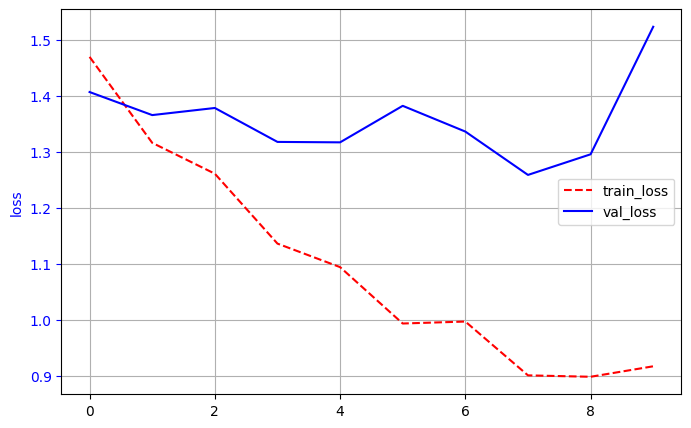

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'r--',label='train_loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

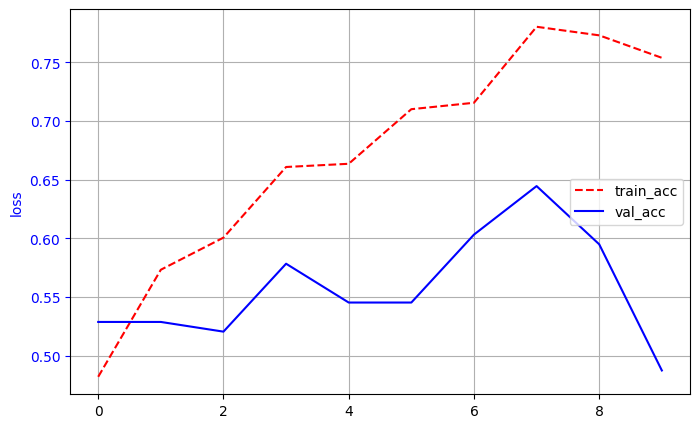

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

his = history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_acc'], 'r--',label='train_acc')
ln2 = ax.plot(his['val_acc'], 'b-',label='val_acc')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

lns = ln1 + ln2
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

## **Evaluate on test set**

In [ ]:
class TestManager:
    """
    Manages the evaluation process for a DINOv3-based video classification model.
    """
    def __init__(self, config: 'Config', device: str, checkpoint_name: str):
        self.config = config
        self.device = device
        self.checkpoint_name = checkpoint_name # Store checkpoint name
        self.num_classes = len(config.labels)
        self.model = self._load_model()
        self.test_loader = self._create_dataloader()
        self.metrics = self._initialize_metrics()
        self.softmax = nn.Softmax(dim=1)

    def _load_model(self):
        """Loads the DINOv3-based video classifier and the fine-tuned checkpoint."""
        print("Loading model and best checkpoint...")

        # model = DINOv3VideoClassifier(
        #     repo_dir='dinov3',
        #     model='dinov3_vitl16',
        #     pretrained=False,
        #     # weights_path='dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth',
        #     fine_tune_backbone=False,   # start frozen, unfreeze later if needed
        #     complex_head=False,         # or True for a bigger head
        #     num_classes=13,
        #     probe_layers=4,             # the "small 4-layer attentive probe"
        #     probe_heads=8,
        #     probe_dropout=0.5,
        #     frame_batch_size=128
        # ).to(device)

        model = DINOv3VideoLSTMClassifier(
            repo_dir='dinov3',
            model='dinov3_vitl16',
            pretrained=False,
            # weights_path='dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth',
            fine_tune_backbone=False,      # start frozen
            num_classes=12,
            frame_batch_size=128,
            lstm_hidden=512,
            lstm_layers=2,                 # try 1–2; >2 rarely helps at T<=16
            bidirectional=True,
            lstm_dropout=0.5,
            head_hidden=None,              # or 256 for a tiny MLP head
            head_dropout=0.5
        ).to(device)

        # Load the checkpoint (checkpoint_name must be available)
        model.load_state_dict(torch.load(self.checkpoint_name, map_location=self.device))
        model.eval()

        return model

    def _create_dataloader(self):
        """Creates and returns the DataLoader for the test set."""
        # Assuming VideoClipDataset and os.path.join are available
        test_ds = VideoClipDataset(os.path.join(self.config.splits_dir, "test.csv"), self.config, train=False)
        return DataLoader(
            test_ds,
            batch_size=max(1, self.config.batch_size),
            shuffle=False,
            num_workers=2,
            pin_memory=True,
            persistent_workers=False
        )

    def _initialize_metrics(self):
        """Initializes all the evaluation metrics."""
        # Metrics remain the same, they are independent of the model architecture
        return {
            'top1': MulticlassAccuracy(num_classes=self.num_classes, average="micro").to(self.device),
            'top3': MulticlassAccuracy(num_classes=self.num_classes, top_k=3).to(self.device),
            'f1_macro': MulticlassF1Score(num_classes=self.num_classes, average="macro").to(self.device),
            'f1_perclass': MulticlassF1Score(num_classes=self.num_classes, average=None).to(self.device),
            'cm': MulticlassConfusionMatrix(num_classes=self.num_classes).to(self.device)
        }

    def run_inference(self):
        """Runs the inference loop and computes all metrics and predictions."""
        print("Starting inference on the test set...")
        test_loss = 0.0
        criterion = nn.CrossEntropyLoss()
        all_predictions = []

        with torch.no_grad(), torch.amp.autocast(self.device, enabled=(self.device == "cuda")):

            # --- Renamed input variables for clarity (no list unpacking needed) ---
            for batch_idx, (video_input, y) in enumerate(self.test_loader):

                # The video_input tensor is already shape (B, T, C, H, W) due to DataLoader stacking.

                # --- NO LIST CHECKING OR SLOWFAST LOGIC NEEDED ---
                video = video_input.to(self.device, non_blocking=True) # Direct assignment and move to device
                y = y.to(self.device, non_blocking=True)

                # DINOv3 model expects (B, T, C, H, W)
                logits = self.model(video)
                # --------------------------------------------------

                loss = criterion(logits, y)
                test_loss += loss.item() * y.size(0)

                # Update metrics
                for metric in self.metrics.values():
                    metric.update(logits, y)

                # ... (rest of the prediction collection logic remains the same)
                probs = self.softmax(logits)
                conf, pred = probs.max(dim=1)
                topk_conf, topk_idx = probs.topk(3, dim=1)

                start_idx = batch_idx * self.test_loader.batch_size

                for i in range(y.size(0)):
                    idx = start_idx + i
                    # NOTE: Assuming 'self.test_loader.dataset.items' is accessible and correct
                    path = self.test_loader.dataset.items[idx][0]
                    row = {
                        "path": path,
                        "file": os.path.basename(path),
                        "true_idx": int(y[i]),
                        "true_label": self.config.labels[int(y[i])],
                        "pred_idx": int(pred[i]),
                        "pred_label": self.config.labels[int(pred[i])],
                        "pred_prob": float(conf[i]),
                        "top1_label": self.config.labels[int(topk_idx[i,0])],
                        "top1_prob":  float(topk_conf[i,0]),
                        "top2_label": self.config.labels[int(topk_idx[i,1])],
                        "top2_prob":  float(topk_conf[i,1]),
                        "top3_label": self.config.labels[int(topk_idx[i,2])],
                        "top3_prob":  float(topk_conf[i,2]),
                    }
                    all_predictions.append(row)

        test_loss /= len(self.test_loader.dataset)
        return test_loss, all_predictions

    def compute_and_print_results(self, test_loss):
        # ... (Same as original)
        acc1 = self.metrics['top1'].compute().item()
        acc3 = self.metrics['top3'].compute().item()
        f1M = self.metrics['f1_macro'].compute().item()
        percls = self.metrics['f1_perclass'].compute().detach().cpu().tolist()
        confmat = self.metrics['cm'].compute().detach().cpu().numpy()

        print(f"\nTEST: loss={test_loss:.4f} | acc@1={acc1*100:.2f}% | acc@3={acc3*100:.2f}% | macro-F1={f1M:.3f}")
        print("\nPer-class F1:")
        for lab, s in sorted(zip(self.config.labels, percls), key=lambda x: x[1], reverse=True):
            print(f"  {lab:15s} {s:.3f}")

        print("\nConfusion Matrix (rows=true, cols=predicted):")
        print(confmat)

    def save_predictions(self, predictions: list, print_n: int=10):
        # ... (Same as original)
        df = pd.DataFrame(predictions)
        save_path = os.path.join(self.config.models_dir, "test_predictions.csv")
        df.to_csv(save_path, index=False)
        print(f"\nSaved per-sample predictions to: {save_path}")
        print("\nQuick peek at the predictions:")
        with pd.option_context('display.max_rows', None):
            print(df.head(print_n)[["file", "true_label", "pred_label", "pred_prob", "top2_label", "top2_prob", "top3_label", "top3_prob"]])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

test_manager = TestManager(cfg, device, checkpoint_name)
test_loss, all_predictions = test_manager.run_inference()

test_manager.compute_and_print_results(test_loss)
test_manager.save_predictions(all_predictions, print_n=len(all_predictions))

Loading model and best checkpoint...
Starting inference on the test set...

TEST: loss=1.6429 | acc@1=40.00% | acc@3=62.96% | macro-F1=0.238

Per-class F1:
  serve           1.000
  block           0.667
  straight_net    0.667
  lift            0.286
  smash           0.000
  jump_smash      0.000
  drop            0.000
  clear           0.000
  drive           0.000
  cross_net       0.000
  push            0.000
  tap             0.000

Confusion Matrix (rows=true, cols=predicted):
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 3 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 4 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 1 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]

Saved per-sample predictions to: ./train_shi_vit/test_predictions.csv

Quick peek at the predictions:
              file    true_label    pred_label  pred_prob    top2_label  \
0   38

## **end-to-end match inference & overlay**

In [ ]:
!pip -q install ultralytics opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00


In [ ]:
import os, cv2, numpy as np, torch
from collections import deque, defaultdict
from ultralytics import YOLO
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_slowfast_classifier(cfg, ckpt_path):
    torch.hub._validate_not_a_forked_repo = lambda a,b,c: True
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r101', pretrained=True)
    in_dim = model.blocks[-1].proj.in_features
    model.blocks[-1].proj = torch.nn.Linear(in_dim, len(cfg.labels))
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval().to(device)
    return model

In [ ]:
def resize_pad_square(img_rgb: np.ndarray, side: int = 224) -> np.ndarray:
    """Keep aspect ratio; resize the longer side to `side`, then pad to (side, side)."""
    h, w = img_rgb.shape[:2]
    if h == 0 or w == 0:
        return np.zeros((side, side, 3), dtype=img_rgb.dtype)
    scale = side / max(h, w)
    nh, nw = int(round(h * scale)), int(round(w * scale))
    resized = cv2.resize(img_rgb, (nw, nh), interpolation=cv2.INTER_LINEAR)
    top  = (side - nh) // 2
    bottom = side - nh - top
    left = (side - nw) // 2
    right = side - nw - left
    out = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(128,128,128))
    return out

def expand_box(x1, y1, x2, y2, scale: float, W: int, H: int):
    """Optionally enlarge the bbox to keep some context (e.g., racket)."""
    cx, cy = (x1 + x2) / 2.0, (y1 + y2) / 2.0
    bw, bh = (x2 - x1) * scale, (y2 - y1) * scale
    nx1, ny1 = int(max(0, cx - bw / 2)), int(max(0, cy - bh / 2))
    nx2, ny2 = int(min(W - 1, cx + bw / 2)), int(min(H - 1, cy + bh / 2))
    return nx1, ny1, nx2, ny2

In [ ]:
class SlowFastPredictor:
    def __init__(self, cfg, model):
        self.cfg = cfg
        self.model = model
        self.mean = torch.tensor([0.45, 0.45, 0.45]).view(3,1,1).to(device)
        self.std  = torch.tensor([0.225, 0.225, 0.225]).view(3,1,1).to(device)

    def _prep(self, frames_rgb_list):
        """
        frames_rgb_list: list of 32 frames, each HxWx3 in RGB
        Returns: [slow, fast] tensors shaped (1,C,T,H,W)
        """
        # Stack to (T,H,W,3) -> (T,C,H,W)
        x = torch.from_numpy(np.stack(frames_rgb_list)).permute(0,3,1,2).float() / 255.0  # (T,C,H,W)
        # Resize treating T as batch
        x = F.interpolate(x, size=self.cfg.side, mode="bilinear", align_corners=False)    # (T,C,224,224)
        # Normalize
        mean = self.mean.to(device=x.device, dtype=x.dtype)
        std  = self.std.to(device=x.device, dtype=x.dtype)
        x = (x - mean) / std                                                   # (T,C,224,224)
        # (C,T,H,W)
        x = x.permute(1,0,2,3)
        fast = x.unsqueeze(0).to(device)             # (1,C,32,224,224)
        slow = x[:, ::self.cfg.alpha, :, :].unsqueeze(0).to(device)  # stride-4 -> (1,C,8,224,224)
        return [slow, fast]

    @torch.no_grad()
    def predict_probs(self, frames_rgb_list):
        assert len(frames_rgb_list) == self.cfg.fast_t  # 32
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            inp = self._prep(frames_rgb_list)
            logits = self.model(inp)                  # (1, num_classes)
            probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()
        return probs  # (C,)

In [ ]:
def annotate_match_video(
    cfg,
    video_path,
    out_path,
    yolo_weights="yolo11n.pt", # change to your custom weights if you have them
    person_class=0,            # COCO 'person'
    det_conf=0.5,
    iou=0.5,
    pred_thr=0.60,             # minimum prob to show label
    cooldown=12                # frames to cool after showing a shot to reduce spam
):
    # Get video props for the writer
    cap = cv2.VideoCapture(video_path)
    fps = max(1.0, cap.get(cv2.CAP_PROP_FPS))
    W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(out_path, fourcc, fps, (W, H))

    # Load detector+tracker
    yolo = YOLO(yolo_weights)

    # Load classifier
    clf_model = load_slowfast_classifier(cfg, cfg.best_model_path)
    clf = SlowFastPredictor(cfg, clf_model)

    # Per-track state
    buffers = defaultdict(lambda: deque(maxlen=cfg.fast_t))            # 32-frame RGB crops per track
    last_shown_frame = defaultdict(lambda: -99999)                     # cooldown control
    hist = defaultdict(lambda: deque(maxlen=5))                        # small temporal smoothing buffer

    frame_idx = 0
    for res in yolo.track(source=video_path, stream=True, persist=True,
                          classes=[person_class], conf=det_conf, iou=iou, verbose=False):
        frame_bgr = res.orig_img  # BGR
        h, w = frame_bgr.shape[:2]

        # If no boxes/ids in this frame, just write it
        if res.boxes is None or res.boxes.id is None:
            writer.write(frame_bgr)
            frame_idx += 1
            continue

        ids = res.boxes.id.int().cpu().numpy()
        xyxy = res.boxes.xyxy.int().cpu().numpy()  # (N,4)

        to_draw = []  # (x1,y1,x2,y2,label,prob,tid)

        for j, tid in enumerate(ids):
            x1, y1, x2, y2 = xyxy[j]
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w-1, x2), min(h-1, y2)
            if x2 <= x1 or y2 <= y1:
                continue

            # NEW: enlarge a bit for context (optional, try 1.2–1.4)
            x1, y1, x2, y2 = expand_box(x1, y1, x2, y2, scale=1.25, W=w, H=h)

            # Crop -> RGB -> letterbox to fixed square
            crop = frame_bgr[y1:y2, x1:x2, :]
            if crop.size == 0:
                continue
            crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            crop_rgb = resize_pad_square(crop_rgb, side=cfg.side)  # now every frame is 224x224

            buffers[tid].append(crop_rgb)

            label_to_show = None
            prob_to_show  = 0.0

            # Classify when we have a full 32-frame clip
            if len(buffers[tid]) == cfg.fast_t:
                probs = clf.predict_probs(list(buffers[tid]))  # (C,)
                ci = int(probs.argmax())
                pi = float(probs[ci])
                hist[tid].append((ci, pi))

                # Small smoothing: require at least 2 of the last 3 agreeing + prob >= thr
                if len(hist[tid]) >= 3:
                    last3 = list(hist[tid])[-3:]
                else:
                    last3 = list(hist[tid])

                # Choose the label with the highest mean prob among last3
                if last3:
                    classes = [c for c, p in last3 if cfg.labels[c] != "average_joe" and p >= pred_thr]
                    if classes:
                        # pick the most common; break ties by highest avg prob
                        uniq = set(classes)
                        best_c, best_score = None, -1.0
                        for u in uniq:
                            avgp = np.mean([p for (c, p) in last3 if c == u])
                            score = (classes.count(u), avgp)  # (count, avgp)
                            if score > (classes.count(best_c) if best_c is not None else -1, best_score):
                                best_c, best_score = u, avgp
                        if best_c is not None and (frame_idx - last_shown_frame[tid] >= cooldown):
                            label_to_show = cfg.labels[best_c]
                            prob_to_show = float(best_score)
                            last_shown_frame[tid] = frame_idx

            # Queue drawing if we have a confident non-background label
            if label_to_show is not None:
                to_draw.append((x1, y1, x2, y2, label_to_show, prob_to_show, int(tid)))

        # ---- Draw all overlays on this frame ----
        for (x1, y1, x2, y2, lab, p, tid) in to_draw:
            color = (0, 220, 0)
            cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), color, 2)
            txt = f"#{tid} {lab} {p*100:.1f}%"
            cv2.putText(frame_bgr, txt, (x1, max(20, y1-10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA)

        writer.write(frame_bgr)
        frame_idx += 1

    writer.release()
    print(f"Saved annotated video to: {out_path}")

In [ ]:
in_video  = "/content/drive/MyDrive/FIT3163,3164/SlowFast/01_raw/lcw_ld_2016_short/1/master.mp4"
out_video = "/content/match_annotated.mp4"
yolo_weights = "/content/drive/MyDrive/FIT3163,3164/YOLO/my_yolov8_1.pt"

annotate_match_video(cfg, in_video, out_video,
                     yolo_weights=yolo_weights,  # swap if you have a better person/badminton model
                     det_conf=0.35, iou=0.5,
                     pred_thr=0.60, cooldown=12)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorchvideo_main


Saved annotated video to: /content/match_annotated.mp4
